# Sepsis prediction with Strats

- __lean version, run all cells immediate and once__

- physiological features only, no texts

- small dataset `pre_text_small`

## Hardware check

In [3]:
# gpu check
!nvidia-smi

Thu Mar  9 20:30:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:3A:00.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |     21MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [2]:
# check number of cores
import multiprocessing

cores = multiprocessing.cpu_count() 
cores

80

## Environment Prep

In [3]:
! pip install pandas==1.3.4
! pip install tqdm==4.62.3
! pip install numpy==1.21.2
! pip install scikit-learn==0.24.2
! pip install scipy==1.7.1
! pip install setuptools==58.0.4
# # ! pip install sip==4.19.8
# # ! pip install six==1.16.0
# # ! pip install sqlite==3.36.0
# ! pip install tensorboard==1.15.0
# # ! pip install tensorflow==2.3.0
# ! pip install tensorflow-base==1.15.0
# ! pip install tensorflow-estimator==2.3.0
# # ! pip install tensorflow-gpu==1.15.0
# ! pip install tensorflow-gpu==2.3.0
! pip install tensorboard==1.15.0
! pip install tensorflow==2.3.0
! pip install tensorflow-base==1.15.0
! pip install tensorflow-estimator==2.3.0
! pip install tensorflow-gpu==1.15.0
# ! pip uninstall tensorflow tensorflow-gpu
# ! pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.3.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
ERROR: Will not install to the user site because it will lack sys.path precedence to pandas in /pfs/data5/software_uc2/bwhpc/common/jupyter/tensorflow/2023-01-02/lib/python3.8/site-packages

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
ERROR: Will not install to the user site because it will lack sys.path precedence to tqdm in /pfs/data5/software_uc2/bwhpc/common/jupyter/tensorflow/2023-01-02/lib/python3.8/site-packages

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached nu

In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
# from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
import smart_cond as sc
# from google.colab import files

2023-03-09 12:08:34.924508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 12:08:35.054923: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 12:08:37.196177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-03-09 12:08:37.196247: W tensorflow/compil

### Version Check

In [5]:
import tensorflow as tf
print(tf. __version__)

2.11.0


In [6]:
pickle.format_version

'4.0'

## Load Data

In [7]:
# connect to drive
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
#! unzip /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/pre_text_small.zip

In [10]:
# mortality data
data_path = 'pretext_sepsis_small.pkl'
pkl = pickle.load(open(data_path, 'rb'))
# data, oc, train_ind, valid_ind, test_ind = pd.read_pickle(open(data_path, 'rb'))

In [11]:
data = pkl[0]
data

,ts_ind,hour,variable,value,TABLE,mean,std
0,0,0.000000,Age,66.000000,N/A,76.513602,57.563189
1,0,0.000000,Gender,1.000000,N/A,0.438490,0.496218
2,0,0.033333,DBP,-0.523689,chart,59.743475,14.786391
3,0,0.033333,GCS_eye,0.714412,chart,3.233104,1.073465
4,0,0.033333,GCS_motor,0.563824,chart,5.144521,1.517281
...,...,...,...,...,...,...,...
32676974,15842,20.400000,MBP,0.213808,chart,78.249322,17.542276
32676975,15842,20.400000,O2 Saturation,-0.615762,chart,96.753805,4.472193
32676976,15842,20.400000,RR,0.981584,chart,20.809484,8.344186
32676977,15842,20.400000,SBP,-0.379414,chart,119.186279,24.211778


In [12]:
oc = pkl[1]
oc

,ts_ind,HADM_ID,SUBJECT_ID,in_hospital_sepsis
0,0,110404,268,1
1,1,130546,274,0
2,2,192224,279,1
3,3,106909,286,0
4,4,135917,286,0
...,...,...,...,...
15956,13716,132953,94903,1
15957,13717,197546,94912,0
15958,13718,143774,94944,0
15959,13719,123750,94950,0


### Preprocess Data

In [13]:
data.loc[data['variable'] == 'Antibiotics', 'value'] = 1

In [14]:
data.loc[data['variable'] == 'Blood Culture', 'value'] = 1

In [15]:
data.loc[data['variable'] == 'Mechanically ventilated', 'value'] = 1

In [16]:
data = data.dropna()
oc = oc.dropna()

## Load Indices

### Genrate New Patient IDs

In [17]:
ids = oc['SUBJECT_ID'].tolist()
labels = oc['in_hospital_sepsis'].tolist()

new_patient_ids = []
new_labels = []

for i in range(len(labels)):
  # print(i)
  if ids[i] in new_patient_ids:
    continue
  else:
    new_patient_ids.append(ids[i])
    new_labels.append(labels[i])

In [18]:
from collections import Counter
# data ratio
Counter(labels)

Counter({1: 5288, 0: 10555})

#### Split train/val/test 

_on patient level: 64/16/20_

In [19]:
 from sklearn.model_selection import train_test_split

 x, x_test, y, y_test = train_test_split(new_patient_ids, new_labels, test_size=0.2, random_state=1)
 x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

### Generate train_ind/val_ind/test_ind

In [20]:
# train
train_ind = []
ts_ind = oc['ts_ind'].tolist()

for i in range(len(ts_ind)):
  if ids[i] in x_train:
    train_ind.append(ts_ind[i])

In [21]:
test_ind = []

for i in range(len(ts_ind)):
  if ids[i] in x_test:
    test_ind.append(ts_ind[i])
    
# to np.array
test_ind = np.array(test_ind)

In [22]:
valid_ind = []

for i in range(len(ts_ind)):
  if ids[i] in x_val:
    valid_ind.append(ts_ind[i])

# to np.array
valid_ind = np.array(valid_ind)

## Load Forecasting Data into Matrices

In [23]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

In [24]:
# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

25288it [00:00, 885540.05it/s]
100%|██████████| 26/26 [01:26<00:00,  3.31s/it]


## Load Target Dataset into Matrices

In [25]:
# # load data again
# data_path = '/pfs/data5/home/hd/hd_hd/hd_ry236/riezler/data/patient/mimic_iii_preprocessed_finetuning2.pkl'
pkl = pickle.load(open(data_path, 'rb'))
data = pkl[0]
oc = pkl[1]

In [26]:
# preprocess data
data.loc[data['variable'] == 'Mechanically ventilated', 'value'] = 1
data.loc[data['variable'] == 'Blood Culture', 'value'] = 1
data.loc[data['variable'] == 'Antibiotics', 'value'] = 1
data = data.dropna()
oc = oc.dropna()

In [27]:
# train
train_ind = []
ts_ind = oc['ts_ind'].tolist()
# ids = ids
for i in range(len(ts_ind)):
  if ids[i] in x_train:
    train_ind.append(ts_ind[i])
# number of train patients
print(len(x_train))
# number of train instances
print(len(train_ind))
# to np.array
train_ind = np.array(train_ind)
test_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_test:
    test_ind.append(ts_ind[i])
# number of test patients
print(len(x_test))
# number of test instances
print(len(test_ind))
# to np.array
test_ind = np.array(test_ind)
valid_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_val:
    valid_ind.append(ts_ind[i])
# number of test patients
print(len(x_val))
# number of test instances
print(len(valid_ind))
# to np.array
valid_ind = np.array(valid_ind)

6394
10165
1999
3199
1599
2479


In [28]:
# # Read data.
# data_path = './../mimic_iii_preprocessed.pkl'
# data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
# Filter labeled data in first 24h.
data = data.loc[data.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
data = data.loc[(data.hour>=0)&(data.hour<=24)]
oc = oc.loc[oc.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get y and N.
y = np.array(oc.sort_values(by='ts_ind')['in_hospital_sepsis']).astype('float32')
N = data.ts_ind.max() + 1
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Trim to max len.
data = data.sample(frac=1)
data = data.groupby('ts_ind').head(880)
# Get N, V, var_to_ind.
N = data.ts_ind.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Add obs index.
data = data.sort_values(by=['ts_ind']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('ts_ind').agg({'obs_ind':'min'}).reset_index().rename(columns={ \
                                                            'obs_ind':'first_obs_ind'}), on='ts_ind')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']
# Find max_len.
max_len = data.obs_ind.max()+1
print ('max_len', max_len)
# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
values_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32')
for row in tqdm(data.itertuples()):
    ts_ind = row.ts_ind
    l = row.obs_ind
    times_inp[ts_ind, l] = row.hour
    values_inp[ts_ind, l] = row.value
    varis_inp[ts_ind, l] = row.vind
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)
# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
valid_ip = [ip[valid_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
test_ip = [ip[test_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
del times_inp, values_inp, varis_inp
train_op = y[train_ind]
valid_op = y[valid_ind]
test_op = y[test_ind]
del y

31686it [00:00, 810943.82it/s]


max_len 880


5949955it [00:08, 682658.40it/s]


## Define metrics and losses

In [29]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

######################################################################################################## 
######################################################################################################## 
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)
######################################################################################################## 
######################################################################################################## 

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define Model Architecture

In [30]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

## Pretrain on forecasting

In [31]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

# save losses for visualization
val_losses = []
train_losses = []

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    val_losses.append(val_loss)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    train_losses.append(e_loss*batch_size/samples_per_epoch)
    # model should be saved here after each epoch in case of unexpected disconnection
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

2023-03-09 12:15:52.836175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 12:15:54.986995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30926 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-03-09 12:15:54.987690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30933 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 880)]        0           []                               
                                                                                         

  0%|          | 0/3200 [00:00<?, ?it/s]2023-03-09 12:16:04.820697: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x152bbca45a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 12:16:04.820726: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 12:16:04.820731: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 12:16:04.827942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 12:16:05.357813: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
0.354514: 100%|██████████| 3200/3200 [02:38<00:00, 20.19it/s]


1615/1615 [==============================] - 27s 16ms/step - loss: 9.4994
Epoch 0 loss 11.341017503887414 val loss 9.499423027038574


0.280185: 100%|██████████| 3200/3200 [02:28<00:00, 21.61it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 8.4695
Epoch 1 loss 8.963209214583038 val loss 8.469526290893555


0.254693: 100%|██████████| 3200/3200 [02:28<00:00, 21.58it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 8.0389
Epoch 2 loss 8.147709798812866 val loss 8.038850784301758


0.245845: 100%|██████████| 3200/3200 [02:27<00:00, 21.68it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.8942
Epoch 3 loss 7.864650012627244 val loss 7.894153118133545


0.238073: 100%|██████████| 3200/3200 [02:27<00:00, 21.68it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.5062
Epoch 4 loss 7.616029405891895 val loss 7.506176948547363


0.234772: 100%|██████████| 3200/3200 [02:27<00:00, 21.69it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.4528
Epoch 5 loss 7.5104236047714945 val loss 7.452846527099609


0.229373: 100%|██████████| 3200/3200 [02:28<00:00, 21.61it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.2489
Epoch 6 loss 7.337713113874197 val loss 7.248946189880371


0.225652: 100%|██████████| 3200/3200 [02:30<00:00, 21.32it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.2237
Epoch 7 loss 7.218678650259972 val loss 7.223722457885742


0.220602: 100%|██████████| 3200/3200 [02:28<00:00, 21.49it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.1203
Epoch 8 loss 7.057111842334271 val loss 7.120298385620117


0.215807: 100%|██████████| 3200/3200 [02:30<00:00, 21.26it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.0554
Epoch 9 loss 6.903733929544687 val loss 7.055449962615967


0.220266: 100%|██████████| 3200/3200 [02:28<00:00, 21.62it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.2220
Epoch 10 loss 7.046379610225558 val loss 7.2219953536987305


0.215295: 100%|██████████| 3200/3200 [02:28<00:00, 21.61it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.9364
Epoch 11 loss 6.887339868918061 val loss 6.936354637145996


0.213918: 100%|██████████| 3200/3200 [02:27<00:00, 21.63it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.9148
Epoch 12 loss 6.843300604596734 val loss 6.914775371551514


0.215303: 100%|██████████| 3200/3200 [02:27<00:00, 21.64it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.5661
Epoch 13 loss 6.88762027233839 val loss 7.566102504730225


0.210523: 100%|██████████| 3200/3200 [02:29<00:00, 21.43it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.8061
Epoch 14 loss 6.734698004871607 val loss 6.806117534637451


0.210156: 100%|██████████| 3200/3200 [02:28<00:00, 21.55it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.8901
Epoch 15 loss 6.7229601466655735 val loss 6.890071868896484


0.213584: 100%|██████████| 3200/3200 [02:28<00:00, 21.57it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.7899
Epoch 16 loss 6.8326098867505785 val loss 6.789936542510986


0.209187: 100%|██████████| 3200/3200 [02:28<00:00, 21.57it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.7647
Epoch 17 loss 6.6919456638395785 val loss 6.764650344848633


0.207419: 100%|██████████| 3200/3200 [02:29<00:00, 21.43it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.7493
Epoch 18 loss 6.6353846094384785 val loss 6.74928617477417


0.209288: 100%|██████████| 3200/3200 [02:28<00:00, 21.53it/s]


1615/1615 [==============================] - 30s 18ms/step - loss: 6.8310
Epoch 19 loss 6.695187534987927 val loss 6.8310227394104


0.205438: 100%|██████████| 3200/3200 [02:34<00:00, 20.76it/s]


1615/1615 [==============================] - 27s 16ms/step - loss: 6.6980
Epoch 20 loss 6.572023459523916 val loss 6.6979851722717285


0.208927: 100%|██████████| 3200/3200 [02:29<00:00, 21.34it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.6319
Epoch 21 loss 6.683627817332745 val loss 6.631889343261719


0.205792: 100%|██████████| 3200/3200 [02:30<00:00, 21.24it/s]


1615/1615 [==============================] - 27s 17ms/step - loss: 6.5791
Epoch 22 loss 6.583347977548837 val loss 6.579145908355713


0.200637: 100%|██████████| 3200/3200 [02:30<00:00, 21.22it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.6266
Epoch 23 loss 6.418437713012099 val loss 6.6266093254089355


0.207027: 100%|██████████| 3200/3200 [02:29<00:00, 21.39it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.6622
Epoch 24 loss 6.622866421341896 val loss 6.662199974060059


0.209131: 100%|██████████| 3200/3200 [02:28<00:00, 21.55it/s]


1615/1615 [==============================] - 28s 17ms/step - loss: 6.5984
Epoch 25 loss 6.690181195065379 val loss 6.598430156707764


0.205761: 100%|██████████| 3200/3200 [02:36<00:00, 20.44it/s]


1615/1615 [==============================] - 28s 17ms/step - loss: 6.8908
Epoch 26 loss 6.582358309328556 val loss 6.890812397003174


0.203637: 100%|██████████| 3200/3200 [02:39<00:00, 20.01it/s]


1615/1615 [==============================] - 28s 16ms/step - loss: 6.5587
Epoch 27 loss 6.514424600452185 val loss 6.5587029457092285


0.201259: 100%|██████████| 3200/3200 [02:28<00:00, 21.50it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5926
Epoch 28 loss 6.438334880620241 val loss 6.592578887939453


0.200345: 100%|██████████| 3200/3200 [02:28<00:00, 21.48it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5071
Epoch 29 loss 6.409103575497865 val loss 6.5071187019348145


0.202067: 100%|██████████| 3200/3200 [02:28<00:00, 21.53it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5861
Epoch 30 loss 6.464191145077348 val loss 6.586143493652344


0.197291: 100%|██████████| 3200/3200 [02:27<00:00, 21.62it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5118
Epoch 31 loss 6.311394696608186 val loss 6.511788845062256


0.200970: 100%|██████████| 3200/3200 [02:29<00:00, 21.46it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.4976
Epoch 32 loss 6.429096187725663 val loss 6.497555255889893


0.200301: 100%|██████████| 3200/3200 [02:29<00:00, 21.45it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.6353
Epoch 33 loss 6.407693433985114 val loss 6.635293483734131


0.201930: 100%|██████████| 3200/3200 [02:29<00:00, 21.39it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.4754
Epoch 34 loss 6.459815605245531 val loss 6.475375175476074


0.202030: 100%|██████████| 3200/3200 [02:32<00:00, 20.96it/s]


1615/1615 [==============================] - 28s 17ms/step - loss: 6.5414
Epoch 35 loss 6.463013026751578 val loss 6.541431427001953


0.200188: 100%|██████████| 3200/3200 [02:29<00:00, 21.46it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5848
Epoch 36 loss 6.404062121436 val loss 6.584792613983154


0.198274: 100%|██████████| 3200/3200 [02:34<00:00, 20.68it/s]


1615/1615 [==============================] - 28s 16ms/step - loss: 6.4909
Epoch 37 loss 6.34283122703433 val loss 6.490895748138428


0.197463: 100%|██████████| 3200/3200 [02:34<00:00, 20.68it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.4500
Epoch 38 loss 6.316903159543872 val loss 6.450004577636719


0.196904: 100%|██████████| 3200/3200 [02:30<00:00, 21.20it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 7.2052
Epoch 39 loss 6.299004586711526 val loss 7.205242156982422


0.197039: 100%|██████████| 3200/3200 [02:29<00:00, 21.40it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.7853
Epoch 40 loss 6.303353642299771 val loss 6.785251617431641


0.199379: 100%|██████████| 3200/3200 [02:33<00:00, 20.91it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5069
Epoch 41 loss 6.378200959339738 val loss 6.506948947906494


0.196333: 100%|██████████| 3200/3200 [02:28<00:00, 21.53it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5930
Epoch 42 loss 6.2807497571781274 val loss 6.593042373657227


0.199091: 100%|██████████| 3200/3200 [02:29<00:00, 21.38it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.4904
Epoch 43 loss 6.36899002507329 val loss 6.490363121032715


0.198991: 100%|██████████| 3200/3200 [02:29<00:00, 21.38it/s]


1615/1615 [==============================] - 26s 16ms/step - loss: 6.5168
Epoch 44 loss 6.365796281993389 val loss 6.516811370849609


In [32]:
# # save model to G drive
# ! cp /content/mimic_iii_24h_strats_no_interp_with_ss_fore.h5 /content/drive/MyDrive

In [33]:
# # save to local
# files.download(model_path)

### visualize loss over epochs

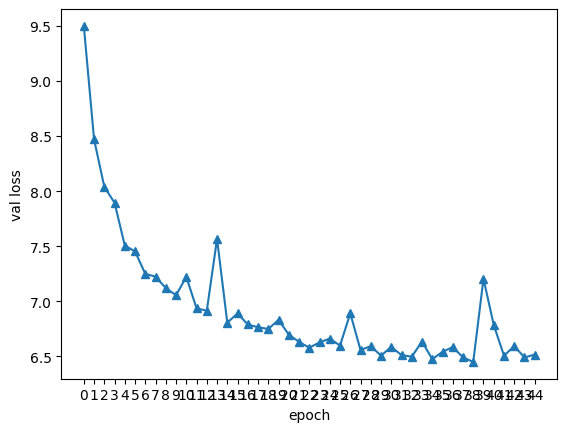

In [34]:
import matplotlib.pyplot as plt

# plot val loss over epochs
plt.plot(range(len(val_losses)), val_losses, marker='^')
plt.xlabel('epoch')
plt.ylabel('val loss')
# plt.xticks(rotation=45, ha='right')
# plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xticks(range(len(val_losses)), range(len(val_losses)))
#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=3)
# save plot
plt.savefig('sepsis_pretext_small_val_loss.png')
plt.show()

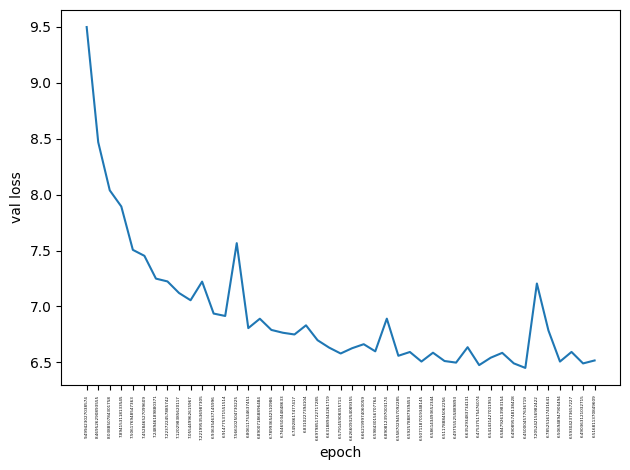

In [39]:
x = range(len(val_losses))
y = val_losses

plt.figure()
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.xticks(x, [str(i) for i in y], rotation=90)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=3)
plt.tight_layout()

# save plot
plt.savefig('sepsis_pretext_small_val_loss.png')
plt.show()

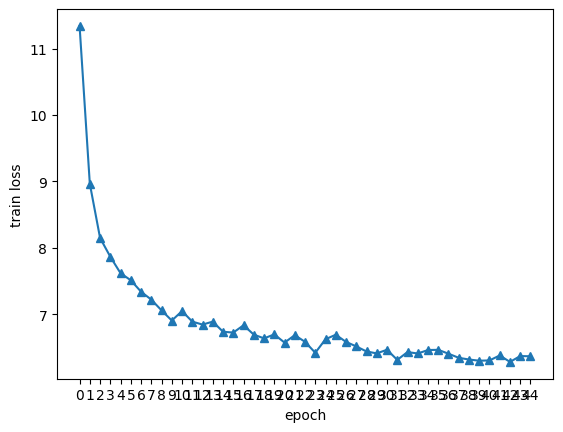

In [35]:
# plot train loss over epochs
plt.plot(range(len(train_losses)), train_losses, marker='^')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.xticks(range(len(train_losses)), range(len(train_losses)))
# save plot
plt.savefig('sepsis_pretext_small_val_loss.png')
plt.show()

In [ ]:
x = range(len(train_losses))
y = train_losses

plt.figure()
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.xticks(x, [str(i) for i in y], rotation=90)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=3)
plt.tight_layout()

# save plot
plt.savefig('sepsis_pretext_small_train_loss.png')
plt.show()

## Target Task

Fine-tune: binary classification

## exp1: forecasting model trained 15 epochs

#### training

In [36]:
repeats = {k:10 for k in [10,20,30,40,50,60]}
lds = [10,20,30,40,50]
batch_size, lr, patience = 32, 0.0005, 10
d, N, he, dropout = 50,2,4,0.2
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'
f = open('log.csv', 'a+')
f.write('\nTraining on different % of labeled data\n')

train_inds = np.arange(len(train_op))
valid_inds = np.arange(len(valid_op))
gen_res = {}

np.random.seed(2021)
for ld in lds:
    np.random.shuffle(train_inds)
    np.random.shuffle(valid_inds)
    train_starts = [int(i) for i in np.linspace(0, len(train_inds)-int(ld*len(train_inds)/100), repeats[ld])]
    valid_starts = [int(i) for i in np.linspace(0, len(valid_inds)-int(ld*len(valid_inds)/100), repeats[ld])]
    f.write('Training on '+str(ld)+' % of labaled data+\n'+'val_metric,roc_auc,pr_auc,min_rp,savepath\n')
    all_test_res = []
    for i in range(repeats[ld]):
        print ('Repeat', i, 'ld', ld)
        # Get train and validation data.
        curr_train_ind = train_inds[np.arange(train_starts[i], train_starts[i]+int(ld*len(train_inds)/100))]
        curr_valid_ind = valid_inds[np.arange(valid_starts[i], valid_starts[i]+int(ld*len(valid_inds)/100))]
        curr_train_ip = [ip[curr_train_ind] for ip in train_ip]
        curr_valid_ip = [ip[curr_valid_ind] for ip in valid_ip]
        curr_train_op = train_op[curr_train_ind]
        curr_valid_op = valid_op[curr_valid_ind]
        print ('Num train:',len(curr_train_op),'Num valid:',len(curr_valid_op))
        # Construct save_path.
        savepath = 'new_mimic_iii_24hm_strats_no_interp_with_ss_repeat'+str(i)+'_'+str(ld)+'ld'+'.h5'
        print (savepath)
        # Build and compile model.
        model, fore_model =  build_strats(D, max_len, V, d, N, he, dropout, forecast=True)
        model.compile(loss=mortality_loss, optimizer=Adam(lr))
        fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
        # Load pretrained weights here.
        fore_model.load_weights(fore_savepath)
        # Train model.
        es = EarlyStopping(monitor='custom_metric', patience=patience, mode='max', 
                           restore_best_weights=True)
        cus = CustomCallback(validation_data=(curr_valid_ip, curr_valid_op), batch_size=batch_size)
        his = model.fit(curr_train_ip, curr_train_op, batch_size=batch_size, epochs=1000,
                        verbose=1, callbacks=[cus, es]).history
        model.save_weights(savepath)
        # Test and write to log.
        rocauc, prauc, minrp = get_res(test_op, model.predict(test_ip, verbose=0, batch_size=batch_size))
        f.write(str(np.min(his['custom_metric']))+str(rocauc)+str(prauc)+str(minrp)+savepath+'\n')
        print ('Test res', rocauc, prauc, minrp)
        all_test_res.append([rocauc, prauc, minrp])
        
    gen_res[ld] = []
    for i in range(len(all_test_res[0])):
        nums = [test_res[i] for test_res in all_test_res]
        gen_res[ld].append((np.mean(nums), np.std(nums)))
    print ('gen_res', gen_res)
f.close()

# # save to local
# log_path = '/content/log.csv'
# files.download(log_path)

Repeat 0 ld 10
Num train: 1016 Num valid: 247
new_mimic_iii_24hm_strats_no_interp_with_ss_repeat0_10ld.h5
Epoch 1/1000
32/32 [==============================] - 11s 108ms/step - loss: 0.6452 - custom_metric: 1.5933
Epoch 2/1000
32/32 [==============================] - 2s 50ms/step - loss: 0.5506 - custom_metric: 1.6275
Epoch 3/1000
32/32 [==============================] - 2s 50ms/step - loss: 0.5116 - custom_metric: 1.6388
Epoch 4/1000
32/32 [==============================] - 1s 46ms/step - loss: 0.5033 - custom_metric: 1.6253
Epoch 5/1000
32/32 [==============================] - 1s 46ms/step - loss: 0.4593 - custom_metric: 1.6258
Epoch 6/1000
32/32 [==============================] - 2s 50ms/step - loss: 0.4218 - custom_metric: 1.5500
Epoch 7/1000
32/32 [==============================] - 1s 46ms/step - loss: 0.3722 - custom_metric: 1.6114
Epoch 8/1000
32/32 [==============================] - 1s 46ms/step - loss: 0.3234 - custom_metric: 1.5483
Epoch 9/1000
32/32 [========================

#### visualization

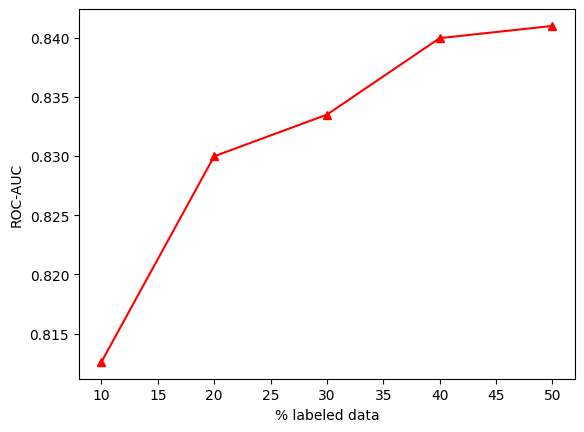

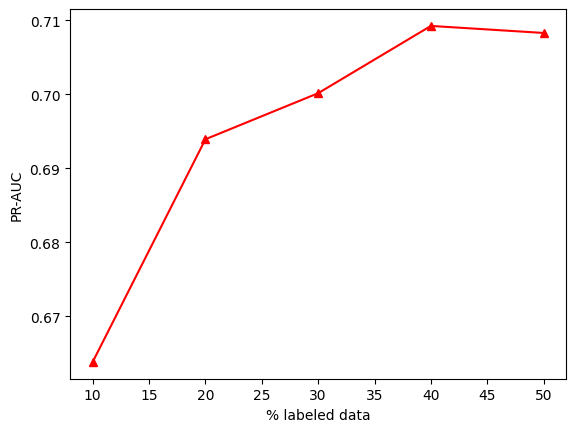

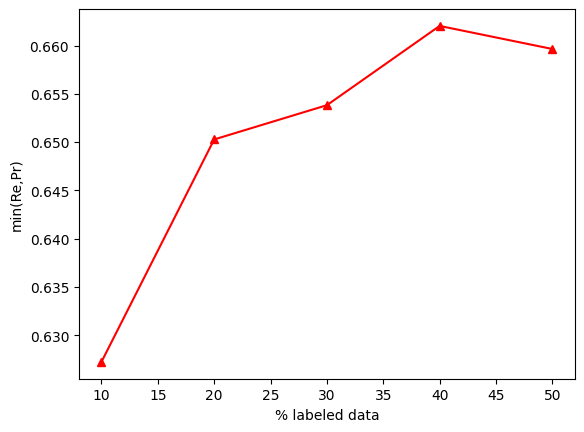

In [37]:
x= range(10,51,10)
for i,metric in enumerate(['ROC-AUC', 'PR-AUC', 'min(Re,Pr)']):
    plt.figure()
    y = [gen_res[ld][i][0] for ld in x]
    plt.plot(x, y, color='r', marker='^')
    plt.xlabel('% labeled data')
    plt.ylabel(metric)
    # save plt
    plt.savefig(metric+'.png')    